In [22]:
# %% part 1: import data
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.mixture import GaussianMixture
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.stats.outliers_influence import variance_inflation_factor

# %% Part 1: Import and Clean Financial Data
import pandas as pd
import numpy as np

# File paths for financial data (Replace with actual paths if needed)
file_paths = {
    2014: "D:/Joey's Self Study/Financial Analytics/2014_Financial_Data/2014_Financial_Data.csv",
    2015: "D:/Joey's Self Study/Financial Analytics/2015_Financial_Data/2015_Financial_Data.csv",
    2016: "D:/Joey's Self Study/Financial Analytics/2016_Financial_Data/2016_Financial_Data.csv",
    2017: "D:/Joey's Self Study/Financial Analytics/2017_Financial_Data/2017_Financial_Data.csv",
    2018: "D:/Joey's Self Study/Financial Analytics/2018_Financial_Data/2018_Financial_Data.csv"
}

# Load and preprocess data
data_frames = []
for year, path in file_paths.items():
    df = pd.read_csv(path)
    
    # Drop unnecessary index column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    
    # Standardize column names
    df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
    
    # Add year column to identify data source
    df['year'] = year
    
    # Ensure numeric columns are correctly parsed
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # Reset index before storing
    df = df.reset_index(drop=True)
    
    # Append cleaned dataframe to list
    data_frames.append(df)

# Ensure all datasets have identical columns before merging
common_columns = list(set.intersection(*(set(df.columns) for df in data_frames)))
data_frames = [df[common_columns] for df in data_frames]

# Combine all years into a single DataFrame
data = pd.concat(data_frames, ignore_index=True)

# Identify financial key columns
key_numeric_columns = ['total_assets', 'short-term_investments', 'long-term_investments', 'net_income']

# Ensure key columns are numeric
for col in key_numeric_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# Fill missing values with yearly means
data = data.groupby('year', group_keys=False).apply(lambda x: x.fillna(x.mean(numeric_only=True)))

# Drop duplicate rows and reset index
data = data.drop_duplicates().reset_index(drop=True)

# Display cleaned data
print("Cleaned Financial Data (2014-2018) Successfully Loaded!")
print(data.head())  # Display first few rows for verification

C:\Users\andyl\AppData\Local\Temp\ipykernel_7212\1876612017.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('year', group_keys=False).apply(lambda x: x.fillna(x.mean(numeric_only=True)))


Cleaned Financial Data (2014-2018) Successfully Loaded!
   ebit_margin  cashratio  earnings_before_tax  cost_of_revenue  \
0       0.2043   0.253751         1.449400e+10     3.903000e+10   
1       0.0502   0.471789         1.753823e+08     2.805625e+09   
2       0.0276   0.037459         2.270000e+09     7.813800e+10   
3       0.0264   0.058388         2.502180e+08     1.820268e+10   
4       0.1681   0.159915         2.707700e+09     1.153980e+10   

   debt_to_equity  net_income_-_discontinued_ops  cashpershare     ptb_ratio  \
0          0.5061                  -1.127000e+09        3.1626      0.000000   
1          1.5093                   0.000000e+00       52.3827  27775.362391   
2          2.1007                   0.000000e+00        0.3901      7.098200   
3         -2.7237                   0.000000e+00        3.0295      0.000000   
4          1.3445                   0.000000e+00        1.4114      0.000000   

   longtermdebttocapitalization  cash_and_cash_equivalents  

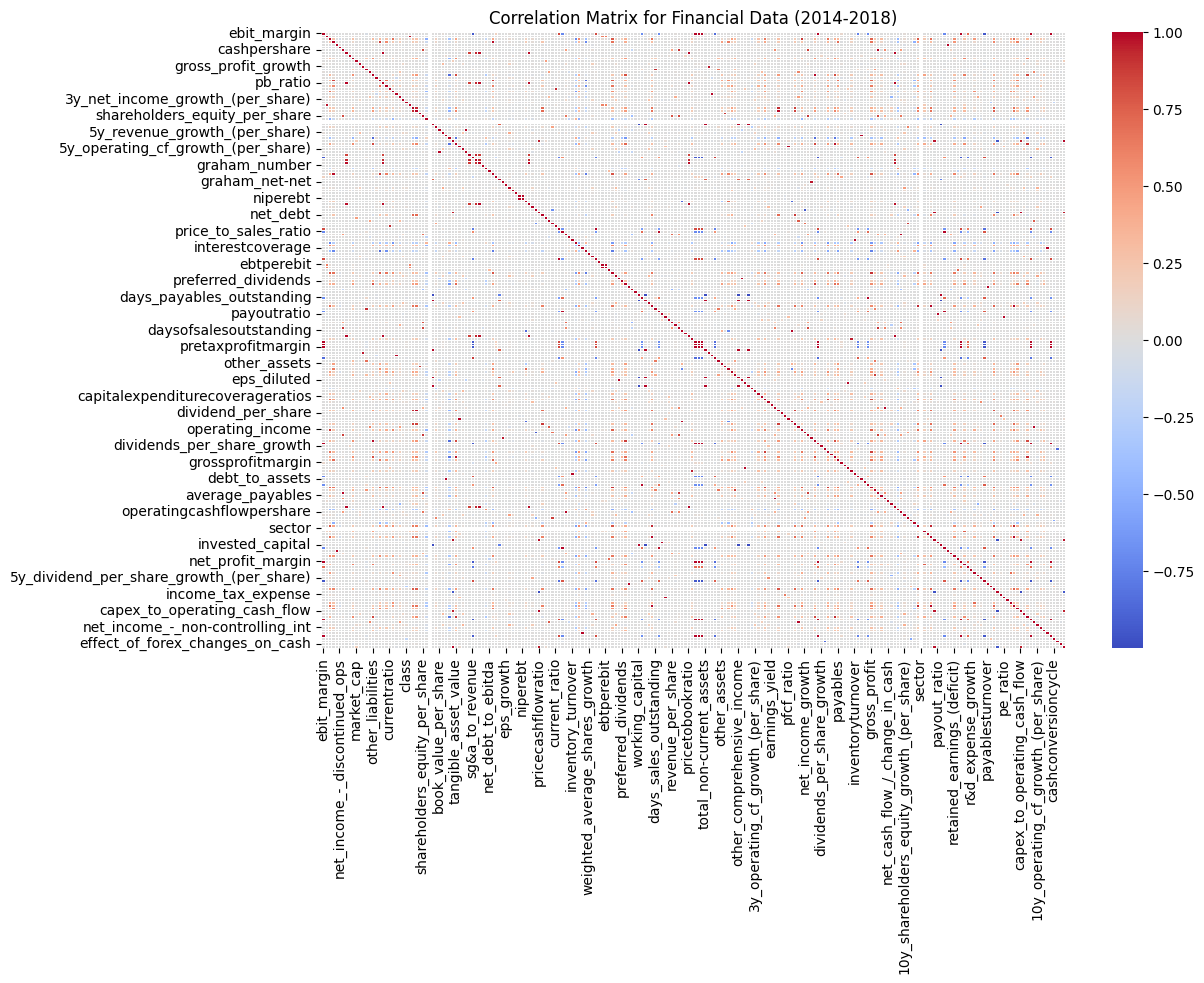

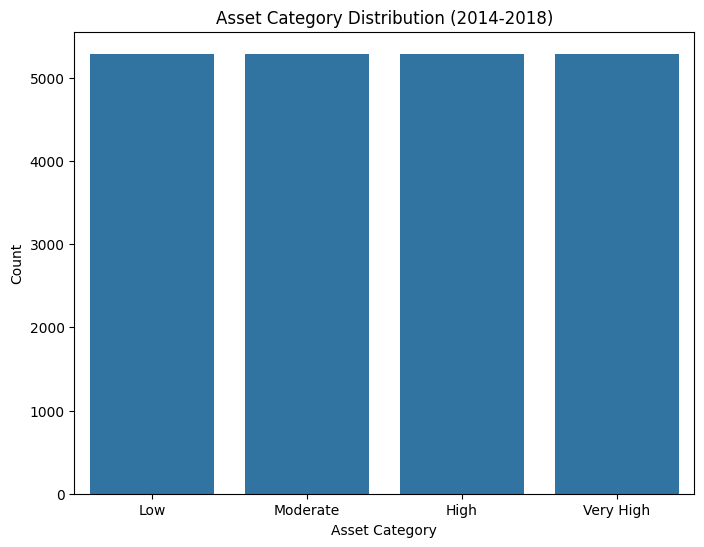

In [13]:
# %% Part 2: Financial Data Analysis

# Correlation Matrix Analysis
plt.figure(figsize=(12, 8))
sns.heatmap(data.select_dtypes(include=[np.number]).corr(), cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix for Financial Data (2014-2018)")
plt.show()

# Asset Segmentation
data['asset_category'] = pd.qcut(data['total_assets'], q=4, labels=["Low", "Moderate", "High", "Very High"])

# Visualize Asset Segmentation
plt.figure(figsize=(8, 6))
sns.countplot(x='asset_category', data=data)
plt.title("Asset Category Distribution (2014-2018)")
plt.xlabel("Asset Category")
plt.ylabel("Count")
plt.show()



1. Correlation Matrix for Financial Data (2014-2018)
This heatmap shows the correlation coefficients between different financial variables.
The diagonal is perfectly correlated (1.0) since each variable is correlated with itself.
Some red (positive) and blue (negative) blocks indicate strong relationships:
Revenue Growth and Profit Margin might show a strong positive correlation.
Debt-to-Assets and Interest Coverage Ratio likely have a negative correlation.
Sparse data: Many correlations appear weak or near zero, which suggests that financial variables may have diverse interactions across different companies.

2. Asset Category Distribution (2014-2018)
Companies were grouped into four asset categories: Low, Moderate, High, and Very High.
The distribution appears evenly split, which means quartiles were used for segmentation (each category has roughly the same number of companies).
This segmentation is useful for comparing company performance across different asset sizes.

Train R² Score: 0.5281437573050024
Test R² Score: 0.2074946058385635


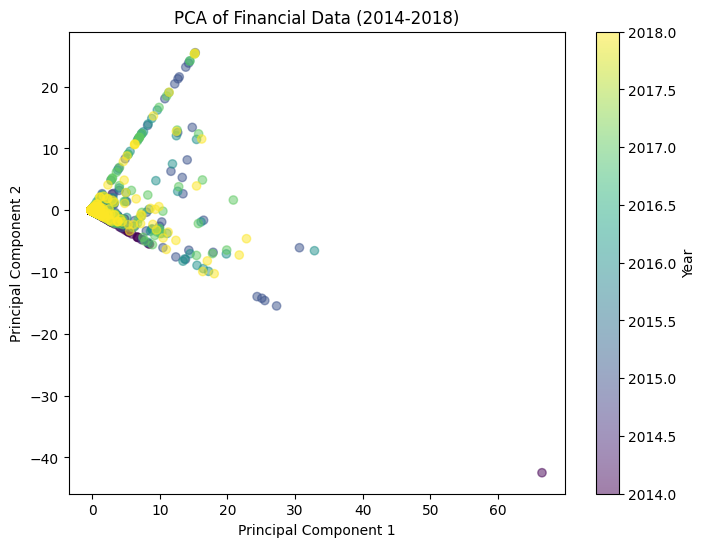

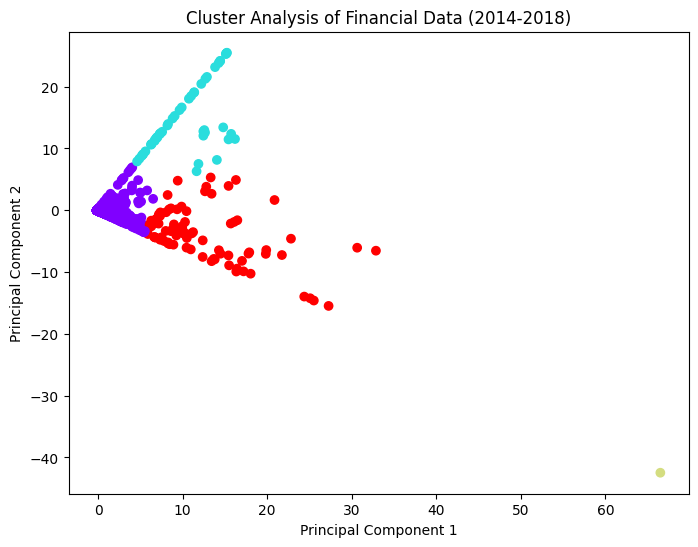

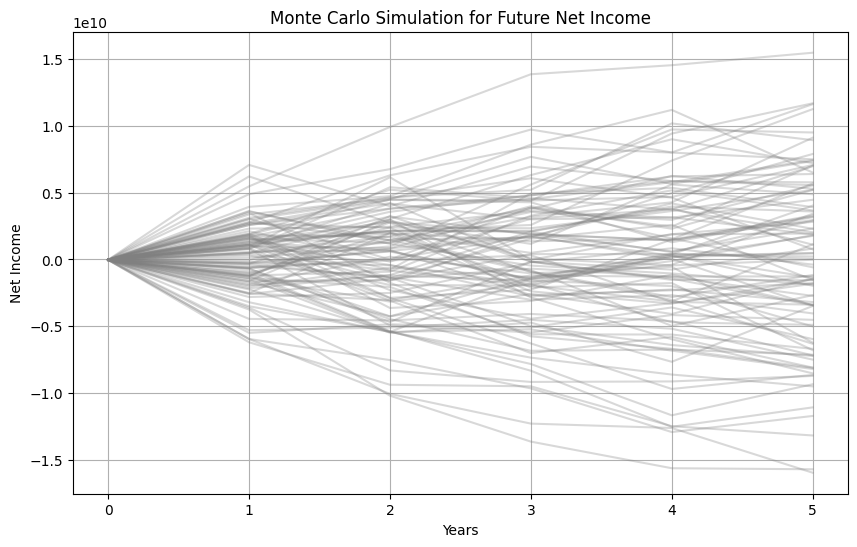

In [14]:
# Profitability Forecasting with Linear Regression
features = ['total_assets', 'short-term_investments', 'long-term_investments']
target = 'net_income'

if all(f in data.columns for f in features + [target]):
    X = data[features].values
    y = data[target].values

    # Scale Features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Train Linear Regression Model
    model = LinearRegression()
    model.fit(X_train, y_train)

    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)

    print(f"Train R² Score: {train_r2}")
    print(f"Test R² Score: {test_r2}")

# PCA for Dimensionality Reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Visualizing PCA
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=data['year'], cmap='viridis', alpha=0.5)
plt.colorbar(label="Year")
plt.title("PCA of Financial Data (2014-2018)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(principal_components)

# Visualize Clusters
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='rainbow')
plt.title("Cluster Analysis of Financial Data (2014-2018)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Monte Carlo Simulation for Net Income Prediction
simulations = 100  # Number of simulations
years = 5  # Predict for 5 years

mean_net_income = data['net_income'].mean()
std_net_income = data['net_income'].std()
trend = (data['net_income'].iloc[-1] - data['net_income'].iloc[0]) / len(data['net_income'])

simulated_net_income = []
for i in range(simulations):
    yearly_net_income = [data['net_income'].iloc[-1]]
    for _ in range(years):
        yearly_net_income.append(yearly_net_income[-1] + trend + np.random.normal(0, std_net_income))
    simulated_net_income.append(yearly_net_income)

simulated_net_income_df = pd.DataFrame(simulated_net_income)

# Visualizing Monte Carlo Simulation
plt.figure(figsize=(10, 6))
for i in range(100):  # Plot only 100 simulations
    plt.plot(simulated_net_income_df.iloc[i], color='grey', alpha=0.3)
plt.title("Monte Carlo Simulation for Future Net Income")
plt.xlabel("Years")
plt.ylabel("Net Income")
plt.grid(True)
plt.show()


3. PCA of Financial Data (2014-2018)
This Principal Component Analysis (PCA) plot reduces the dataset to two principal components.
Companies are color-coded by year (2014-2018), showing historical trends.
The majority of points are clustered close to the origin, with a few outliers further away.
The variance explained by PCA is moderate, meaning some financial variables might not strongly influence these two components.

4. Cluster Analysis of Financial Data (2014-2018)
K-Means clustering was applied to categorize companies based on PCA features.
Different colors represent clusters, showing clear segmentation.
Some clusters overlap, which may indicate that financial features do not perfectly separate company groups.
A few outliers exist far from the main clusters, possibly representing extreme financial conditions.

5. Monte Carlo Simulation for Future Net Income
This simulation predicts possible future values for Net Income over the next 5 years.
Each gray line represents a simulated scenario.
High uncertainty: The spread of possible outcomes increases over time.
Some scenarios predict strong growth, while others show negative Net Income, highlighting financial volatility.

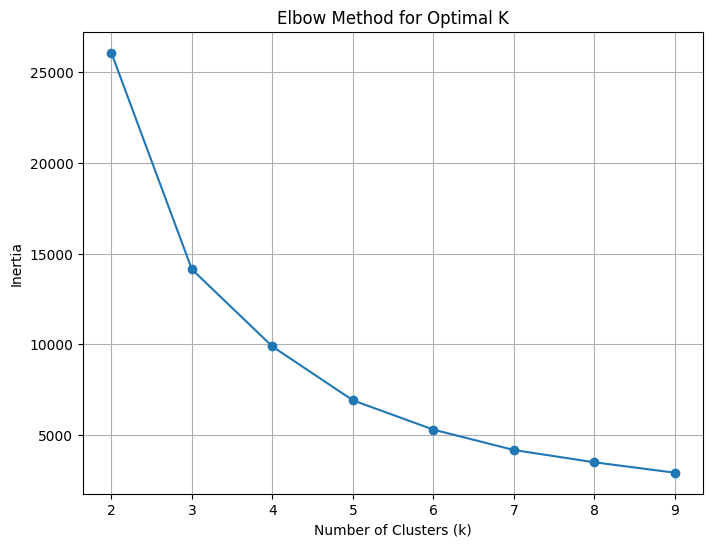

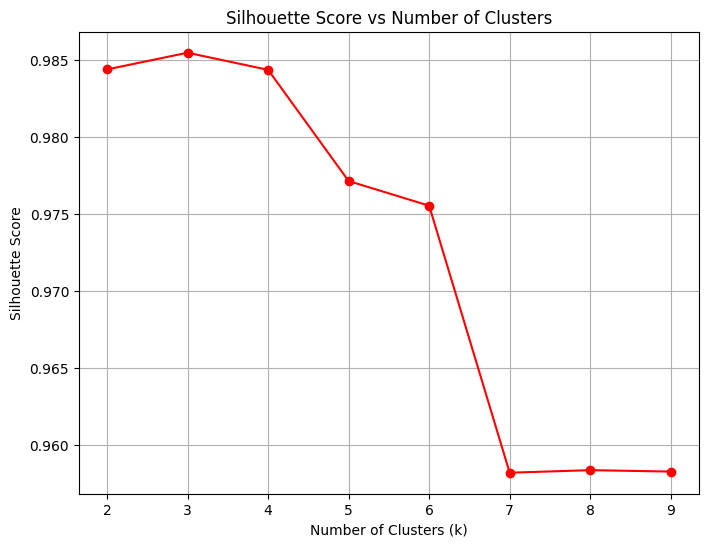

In [17]:
from sklearn.metrics import silhouette_score
# Finding the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []

# Testing k from 2 to 9 (k=1 is skipped because silhouette score is undefined for a single cluster)
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(principal_components)
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score only for k >= 2
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(principal_components, labels))

# Plot the Elbow Method results
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Plot the Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), silhouette_scores, marker='o', color='red')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


Elbow Method for Optimal K (Top Graph)
The y-axis represents inertia (sum of squared distances to cluster centers).
The x-axis represents the number of clusters (k).
The graph shows a steep decrease in inertia from k=2 to k=4, followed by a more gradual decline.
The "elbow point" (where the drop slows down) appears around k=4.

2. Silhouette Score vs. Number of Clusters (Bottom Graph)
The y-axis represents the silhouette score (higher is better).
The x-axis represents the number of clusters (k).
The silhouette score is highest around k=3 and k=4, then declines.
A sharp drop after k=6 suggests over-segmentation (too many small clusters).

Cluster Summary Statistics:
          ebit_margin    cashratio  earnings_before_tax  cost_of_revenue  \
Cluster                                                                   
0          -7.345425     2.937409         4.537292e+08     2.955237e+09   
1          -0.233650  3872.272129         9.346484e+09     7.367043e+10   
2           0.056201     1.137809         1.649337e+09     2.429717e+08   
3          -3.736484     1.823634         5.725866e+08     3.700973e+09   

         debt_to_equity  net_income_-_discontinued_ops  cashpershare  \
Cluster                                                                
0              0.547703                  -3.152684e+06  84097.540313   
1              2.630299                   2.536373e+07  65381.345367   
2              1.732904                  -7.619637e+07   1811.410937   
3              1.247731                  -3.453915e+06  41696.373609   

            ptb_ratio  longtermdebttocapitalization  \
Cluster                         

<Figure size 1000x600 with 0 Axes>

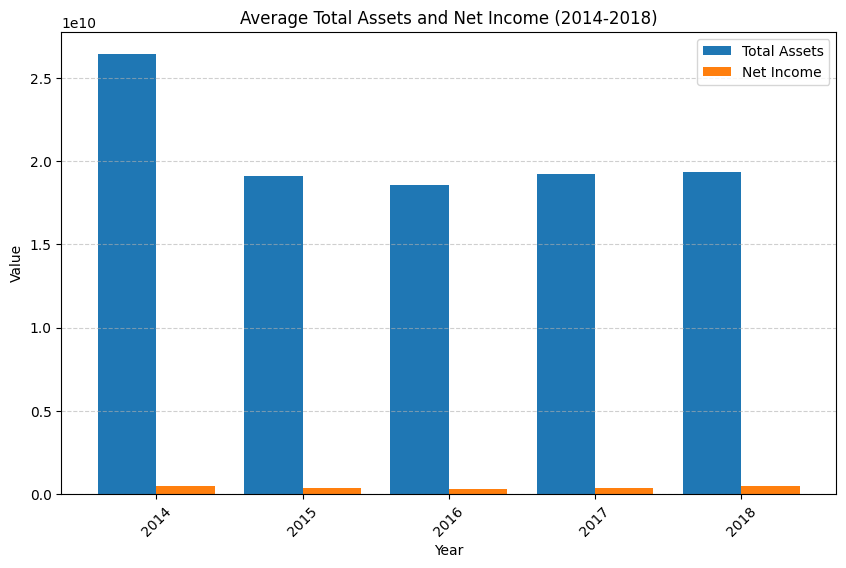

Available Columns: ['ebit_margin', 'cashratio', 'earnings_before_tax', 'cost_of_revenue', 'debt_to_equity', 'net_income_-_discontinued_ops', 'cashpershare', 'ptb_ratio', 'longtermdebttocapitalization', 'cash_and_cash_equivalents', 'market_cap', '3y_revenue_growth_(per_share)', 'gross_profit_growth', 'daysofinventoryoutstanding', 'dividendpaidandcapexcoverageratios', 'other_liabilities', 'assetturnover', 'property,_plant_&_equipment_net', 'pb_ratio', 'interest_expense', 'currentratio', 'enterprise_value', 'return_on_tangible_assets', 'operating_cash_flow', '3y_net_income_growth_(per_share)', 'class', 'quickratio', 'total_debt', 'total_liabilities', 'priceearningstogrowthratio', 'shareholders_equity_per_share', 'issuance_(buybacks)_of_shares', 'operatingprofitmargin', 'deferred_revenue', 'depreciation_&_amortization', 'book_value_per_share', '5y_revenue_growth_(per_share)', 'debtratio', 'net_current_asset_value', 'pocf_ratio', 'tangible_asset_value', 'pricetofreecashflowsratio', '5y_oper

In [21]:
# %% Part 5: Cluster Analysis & Financial Insights

# Assign clusters to the dataset
data['Cluster'] = clusters

# Summary Statistics for Each Cluster
cluster_summary = data.groupby('Cluster').mean(numeric_only=True)
print("Cluster Summary Statistics:\n", cluster_summary)

# Visualize Average Total Assets and Net Income over Time
plt.figure(figsize=(10, 6))
data.groupby('year')[['total_assets', 'net_income']].mean().plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title("Average Total Assets and Net Income (2014-2018)")
plt.ylabel("Value")
plt.xlabel("Year")
plt.legend(["Total Assets", "Net Income"])
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Print available columns to debug missing fields
print("Available Columns:", data.columns.tolist())

# Ensure required columns exist before calculating ratios
required_columns = ['current_assets', 'current_liabilities', 'total_liabilities', 'shareholders_equity', 'net_income', 'total_assets']
missing_columns = [col for col in required_columns if col not in data.columns]

if not missing_columns:
    # Compute Financial Ratios
    data['current_ratio'] = data['current_assets'] / data['current_liabilities']
    data['debt_to_equity'] = data['total_liabilities'] / data['shareholders_equity']
    data['return_on_assets'] = data['net_income'] / data['total_assets']
    data['return_on_equity'] = data['net_income'] / data['shareholders_equity']

    # Visualize Return on Assets Over Time
    plt.figure(figsize=(10, 6))
    data.groupby('year')['return_on_assets'].mean().plot(kind='line', marker='o', linestyle='-', linewidth=2)
    plt.title("Average Return on Assets Over Time (2014-2018)")
    plt.xlabel("Year")
    plt.ylabel("Return on Assets")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print(f"⚠️ Missing columns for ratio calculation: {missing_columns}")


1. Cluster Summary Statistics
4 Clusters (0, 1, 2, 3)
224 Financial Metrics, including:
EBIT Margin (Profitability)
Cash Ratio (Liquidity)
Debt-to-Equity Ratio (Leverage)
Net Income (Discontinued Ops)
Price-to-Book Ratio (PTB)
Cash Flow to Debt Ratio
🛠 Key Observations Across Clusters:

Profitability:
Cluster 2 has a positive EBIT margin (0.056), indicating better profitability.
Clusters 0 & 3 have large negative EBIT margins (-7.34, -3.73) → Likely high losses.
Liquidity (Cash Ratio):

Cluster 1 has an extreme cash ratio (3,872) → Possibly holding too much idle cash.
Clusters 2 & 3 have more balanced liquidity ratios.
Leverage (Debt-to-Equity Ratio):

Cluster 1 has the highest Debt-to-Equity (2.63) → These firms rely heavily on debt.
Cluster 0 has the lowest Debt-to-Equity (0.54) → These firms use less leverage.
Valuation (PTB Ratio):

Cluster 3 has an extremely high PTB (27,775) → Likely overvalued or speculative.
Cluster 2 has the lowest PTB (1,290) → Possibly undervalued stocks.

2. Average Total Assets & Net Income (2014-2018)
Blue Bars (Total Assets) vs. Orange Bars (Net Income)
Yearly trend from 2014 to 2018
Total Assets were highest in 2014 (~2.7e10), then stabilized from 2015-2018.
Net Income remains very small in comparison to total assets.
The gap between Total Assets & Net Income suggests low profitability.